# FedPDE-Diff: Velocity Models & Experiment Results Visualization

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from pathlib import Path
import glob
import re

plt.rcParams.update({'font.size': 12, 'figure.dpi': 120})

BASE_DIR = Path('.')
DATASET_DIR = BASE_DIR / 'dataset'
RESULT_DIR = BASE_DIR / 'experiment_result'

MODEL_NAMES = ['foothill', 'marmousi', 'bpsalt', 'overthrust']
METHOD_LABELS = {'diffusion': 'Diffusion', 'total_variation': 'Total Variation', 'tikhonov': 'Tikhonov'}
METHOD_COLORS = {'diffusion': '#1f77b4', 'total_variation': '#ff7f0e', 'tikhonov': '#2ca02c'}

def v_normalize(v):
    return (((v - 1500) / 3000) * 2) - 1

## 1. Four Velocity Models

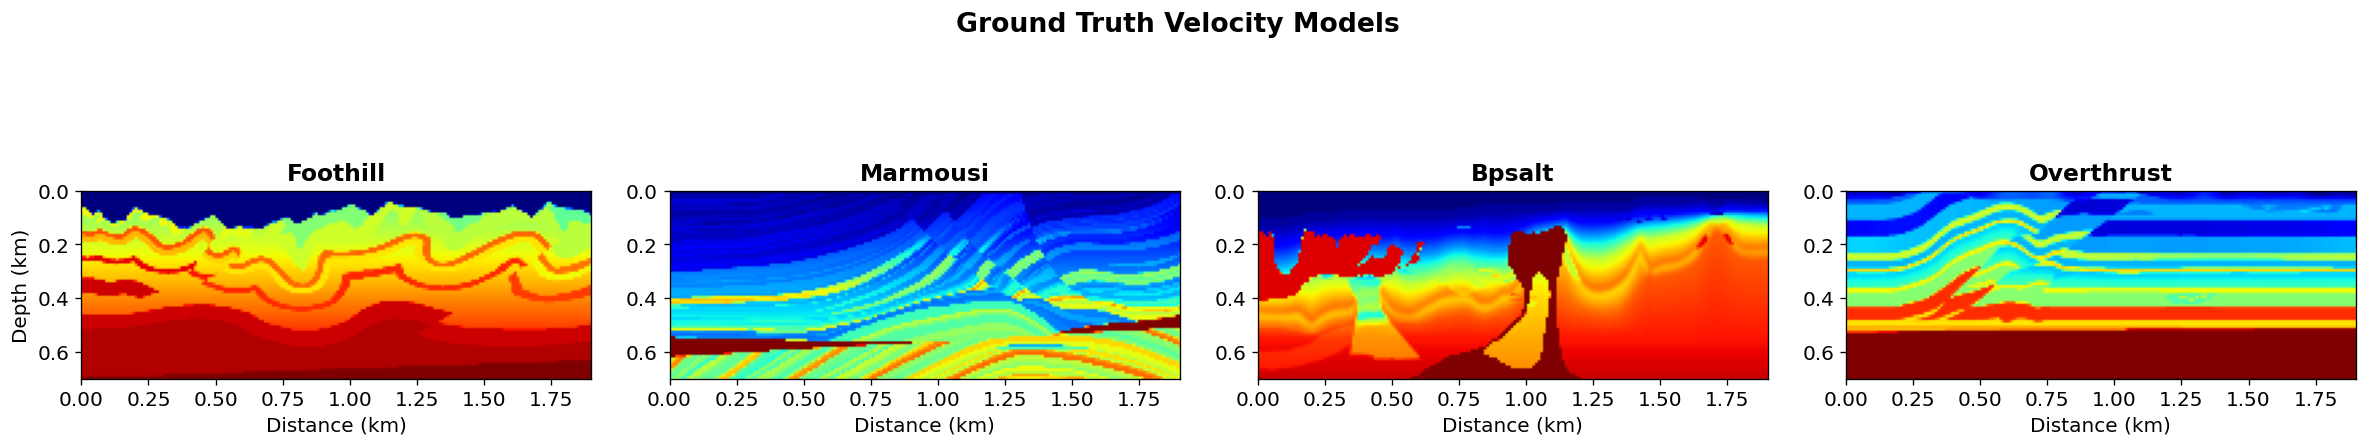

In [2]:
fig, axes = plt.subplots(1, 4, figsize=(20, 4))

for idx, name in enumerate(MODEL_NAMES):
    vm = np.load(DATASET_DIR / name / 'velocity_model' / f'{name}.npy')
    vm_2d = v_normalize(vm[0, 0])  # shape (70, 190), normalized to [-1, 1]
    
    ax = axes[idx]
    im = ax.imshow(vm_2d, aspect='equal', cmap='jet',
                   extent=[0, vm_2d.shape[1]*10/1000, vm_2d.shape[0]*10/1000, 0])
    ax.set_title(name.capitalize(), fontsize=14, fontweight='bold')
    ax.set_xlabel('Distance (km)')
    if idx == 0:
        ax.set_ylabel('Depth (km)')

plt.suptitle('Ground Truth Velocity Models', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

## 2. Experiment Results: Diffusion vs TV vs Tikhonov

For each velocity model and scenario, we show the final inverted velocity model and metrics (SSIM, RMSE, MAE) for all available methods.

In [3]:
# Scan experiment_result/ and organize results by (model, scenario, method)
results = {}  # (model, scenario) -> {method: npz_path}
pattern = re.compile(r'main_FedAvgM_(diffusion|total_variation|tikhonov)_[\d.]+_(.+?)_\d{8}_\d{6}')

for model in MODEL_NAMES:
    model_dir = RESULT_DIR / model
    if not model_dir.exists():
        continue
    for exp_dir in sorted(model_dir.iterdir()):
        if not exp_dir.is_dir():
            continue
        m = pattern.match(exp_dir.name)
        if not m:
            continue
        method, scenario = m.group(1), m.group(2)
        npz_files = list(exp_dir.glob('*.npz'))
        if not npz_files:
            continue
        key = (model, scenario)
        if key not in results:
            results[key] = {}
        results[key][method] = npz_files[0]

# Print summary
print('Available results:')
for (model, scenario), methods in sorted(results.items()):
    method_list = ', '.join(METHOD_LABELS.get(m, m) for m in sorted(methods))
    print(f'  {model:12s} | {scenario:15s} | {method_list}')

Available results:
  bpsalt       | geo_split       | Diffusion, Total Variation
  foothill     | density_split   | Diffusion, Tikhonov, Total Variation
  foothill     | freq_split      | Diffusion, Tikhonov, Total Variation
  foothill     | geo_split       | Diffusion, Tikhonov, Total Variation
  marmousi     | density_split   | Total Variation
  marmousi     | geo_split       | Diffusion, Total Variation
  overthrust   | geo_split       | Diffusion, Total Variation


In [4]:
# Load ground truth models (in [-1, 1] range to match saved results)
gt_models = {}
for name in MODEL_NAMES:
    vm = np.load(DATASET_DIR / name / 'velocity_model' / f'{name}.npy')
    gt_models[name] = v_normalize(vm[0, 0])

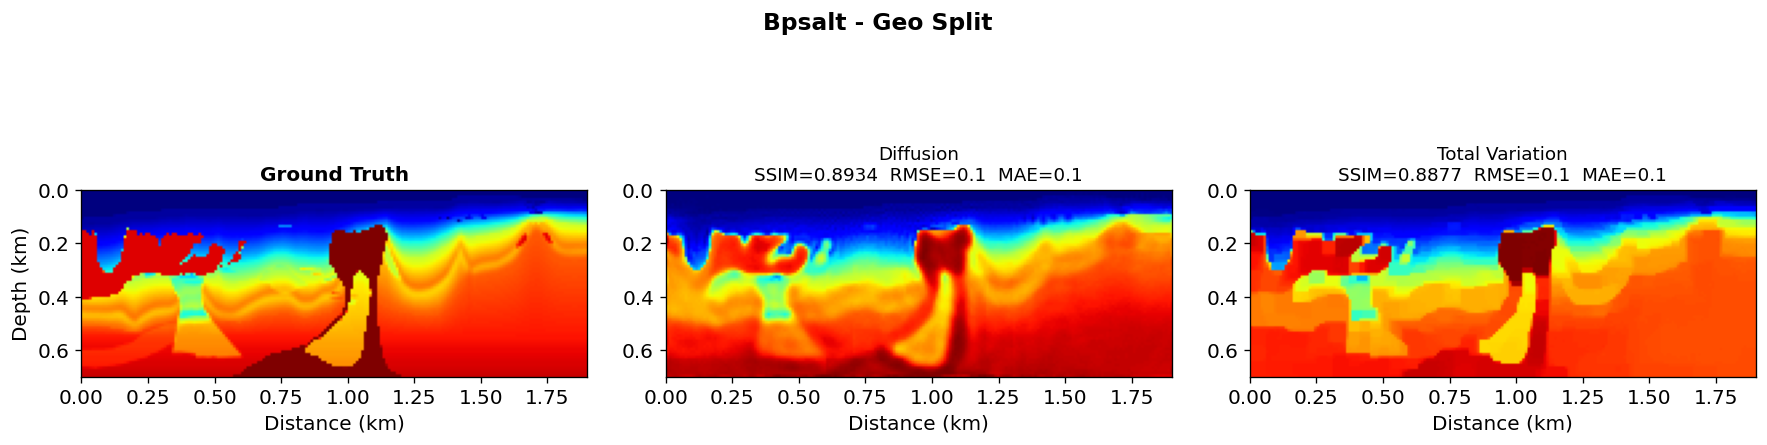

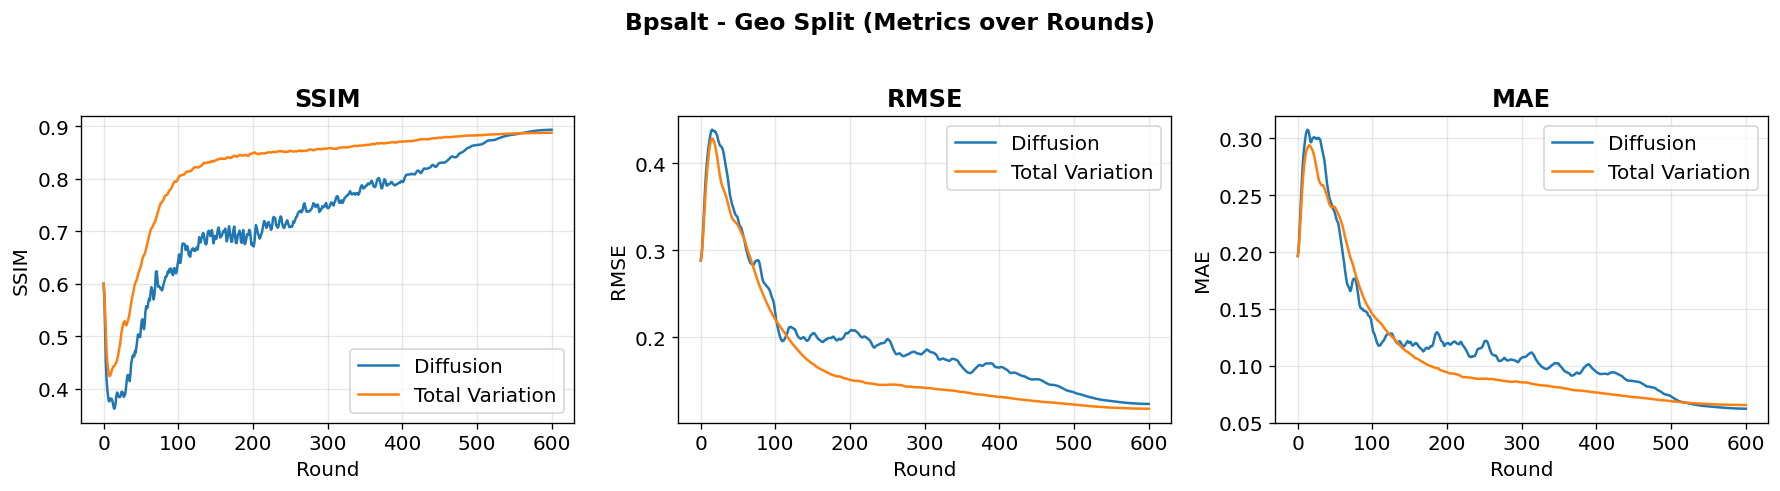

---


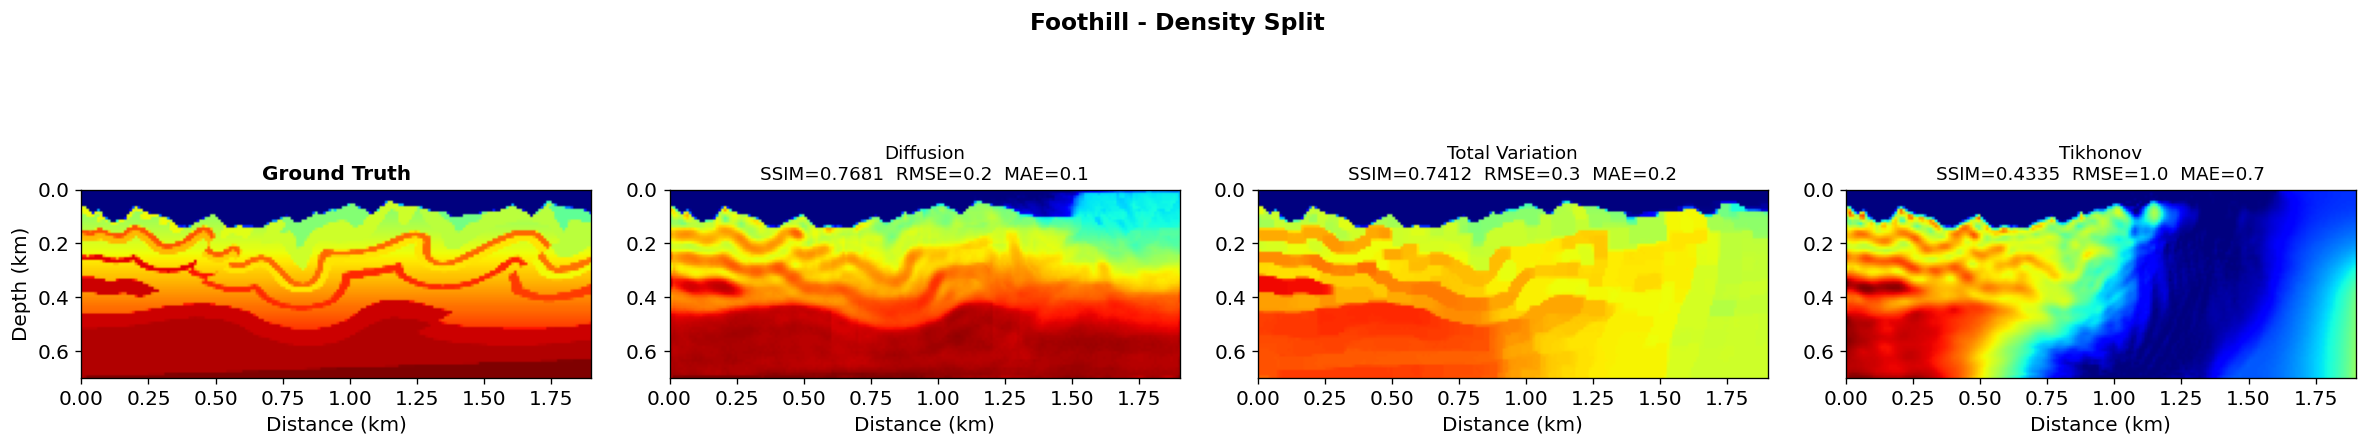

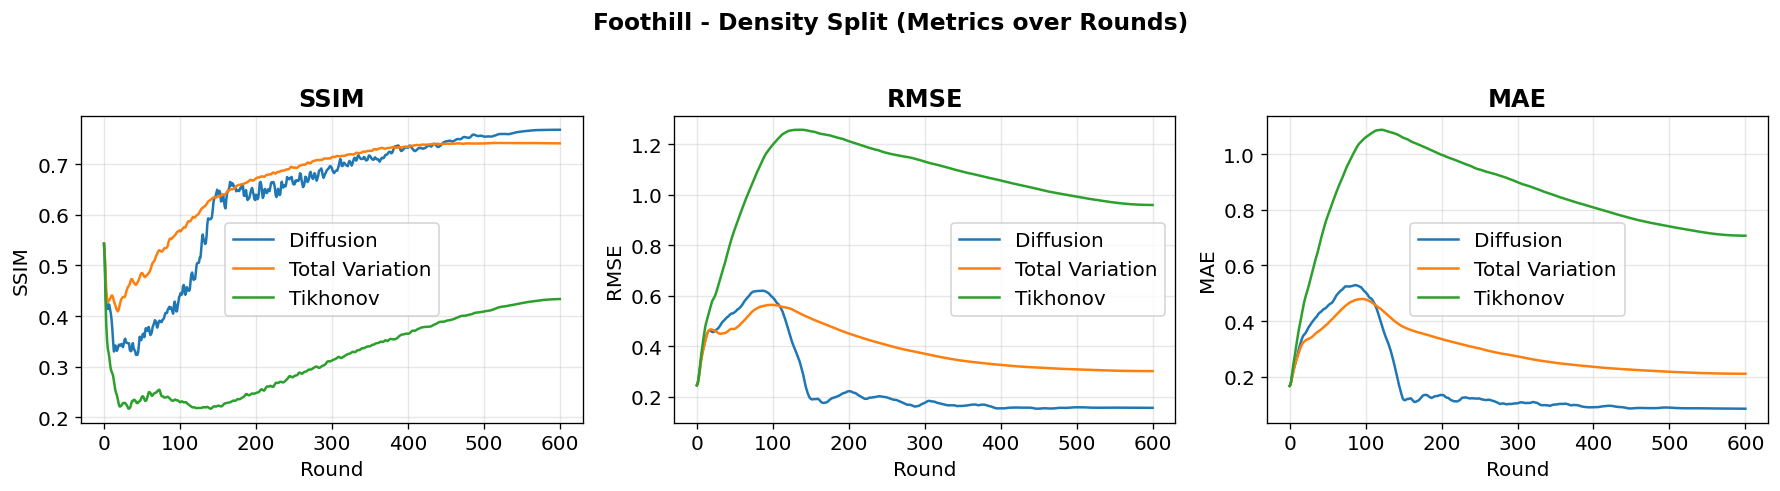

---


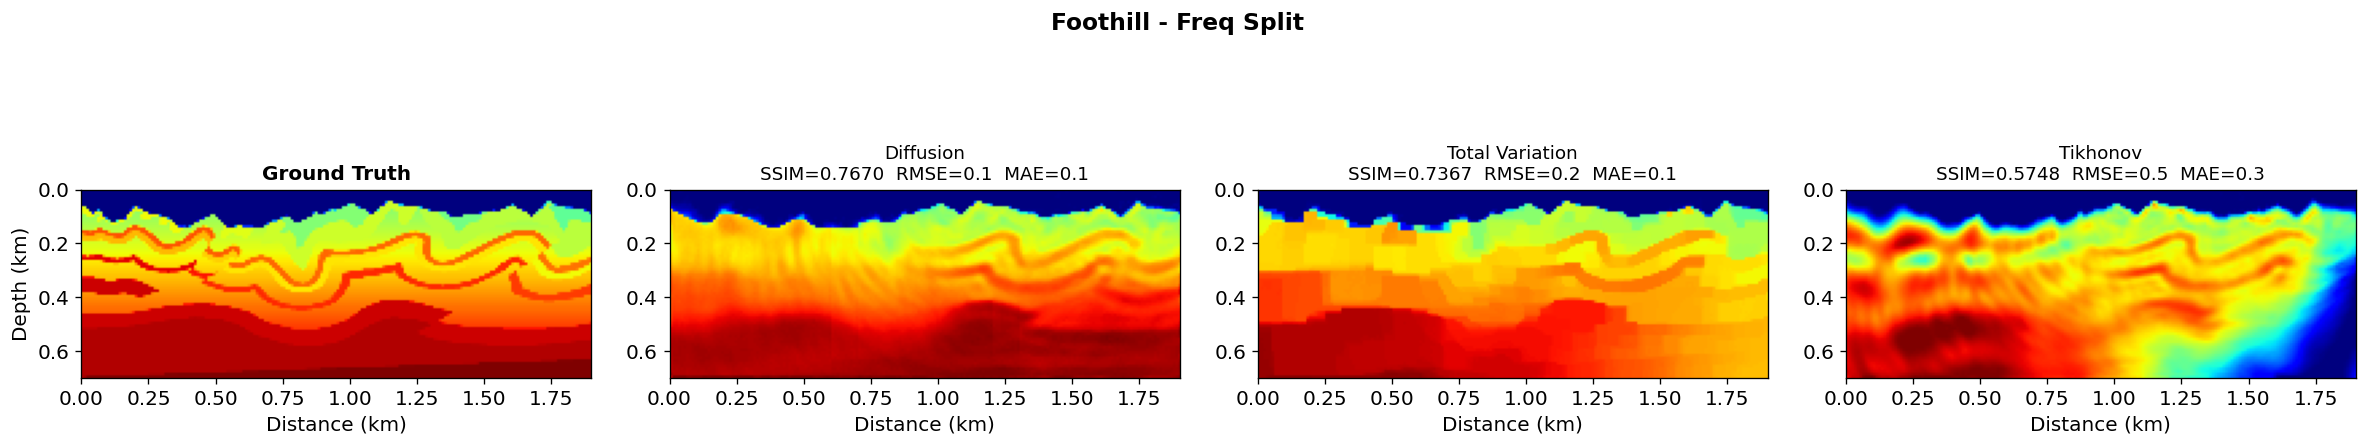

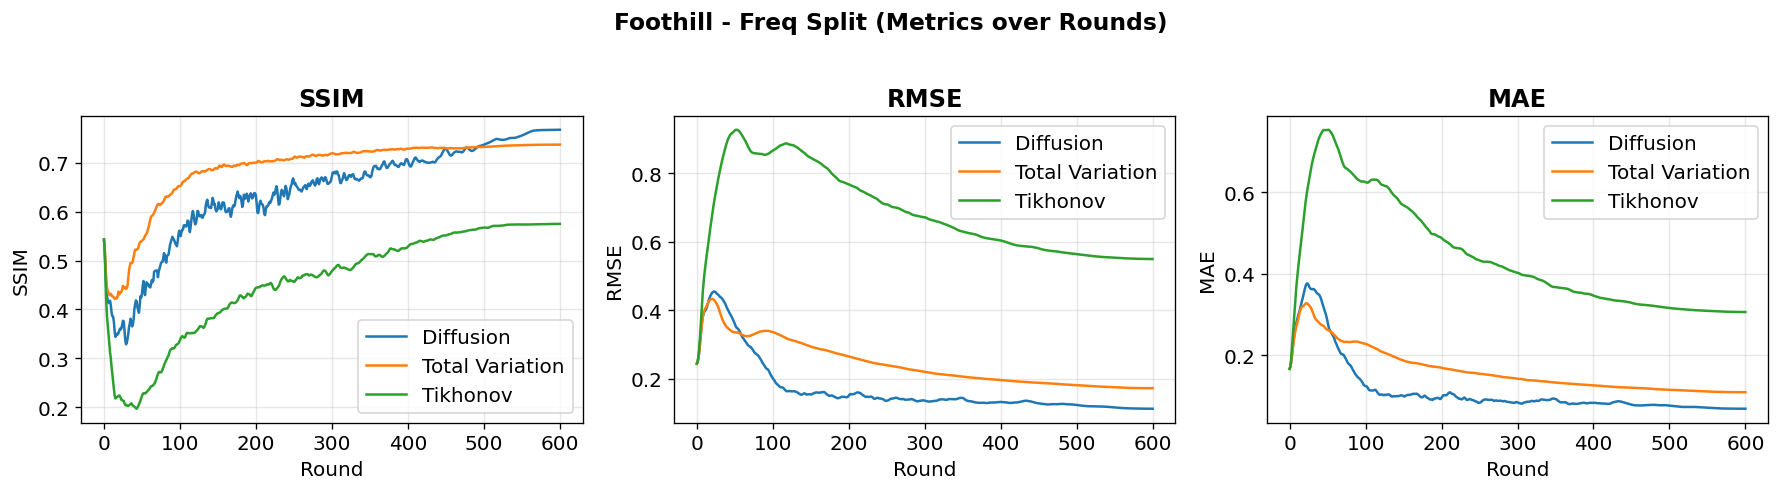

---


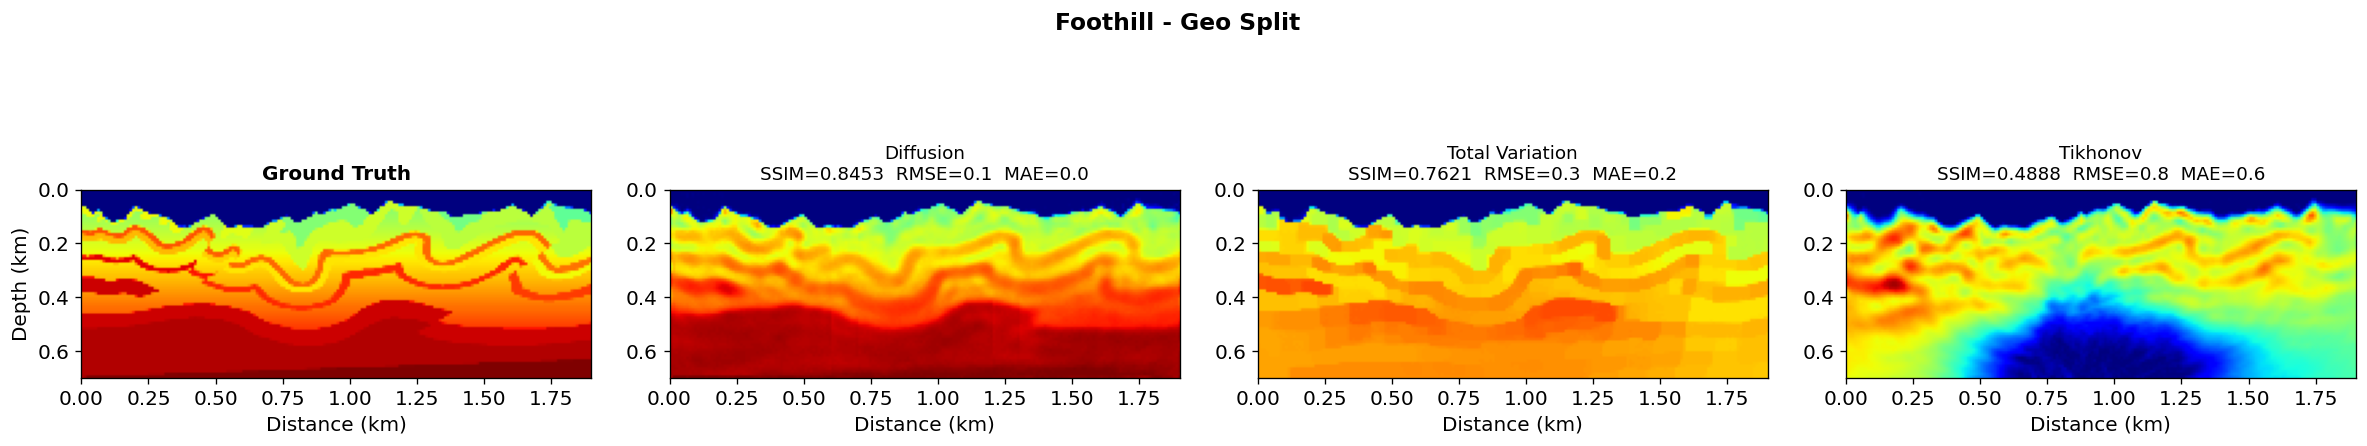

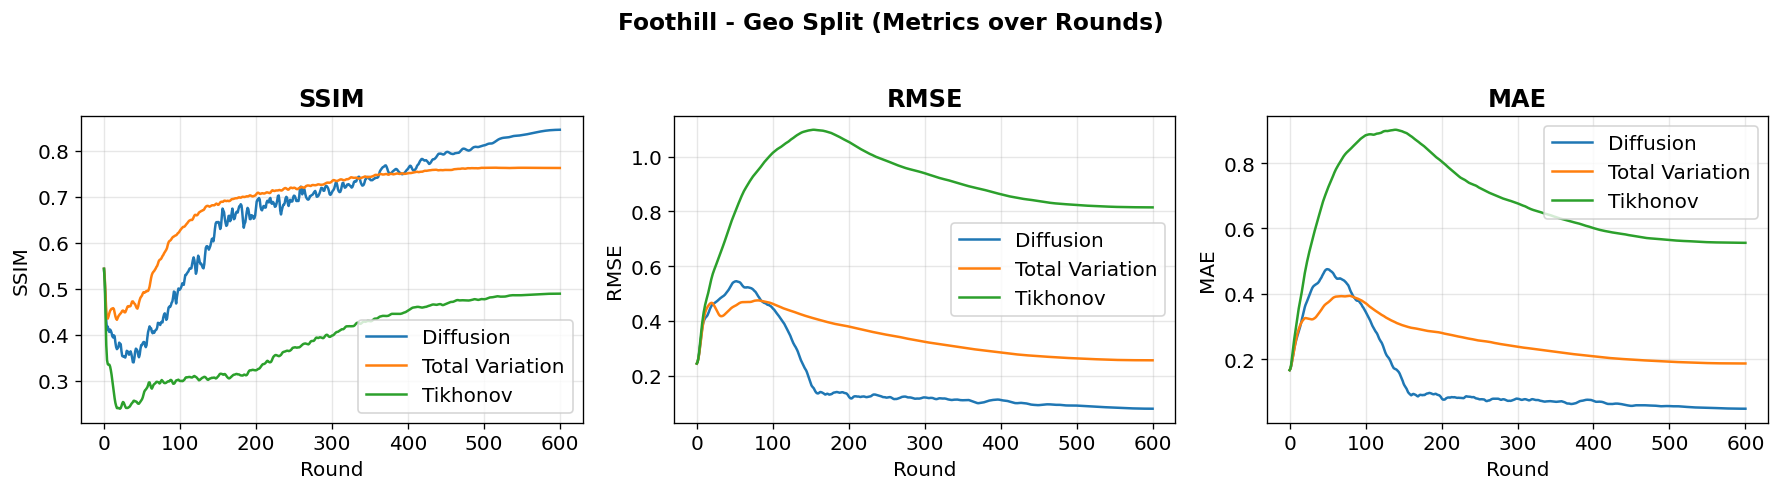

---


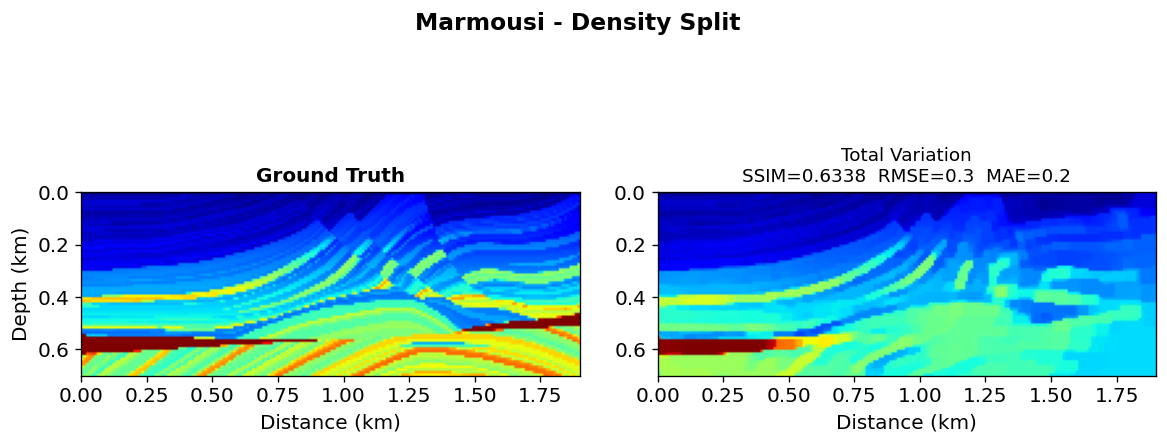

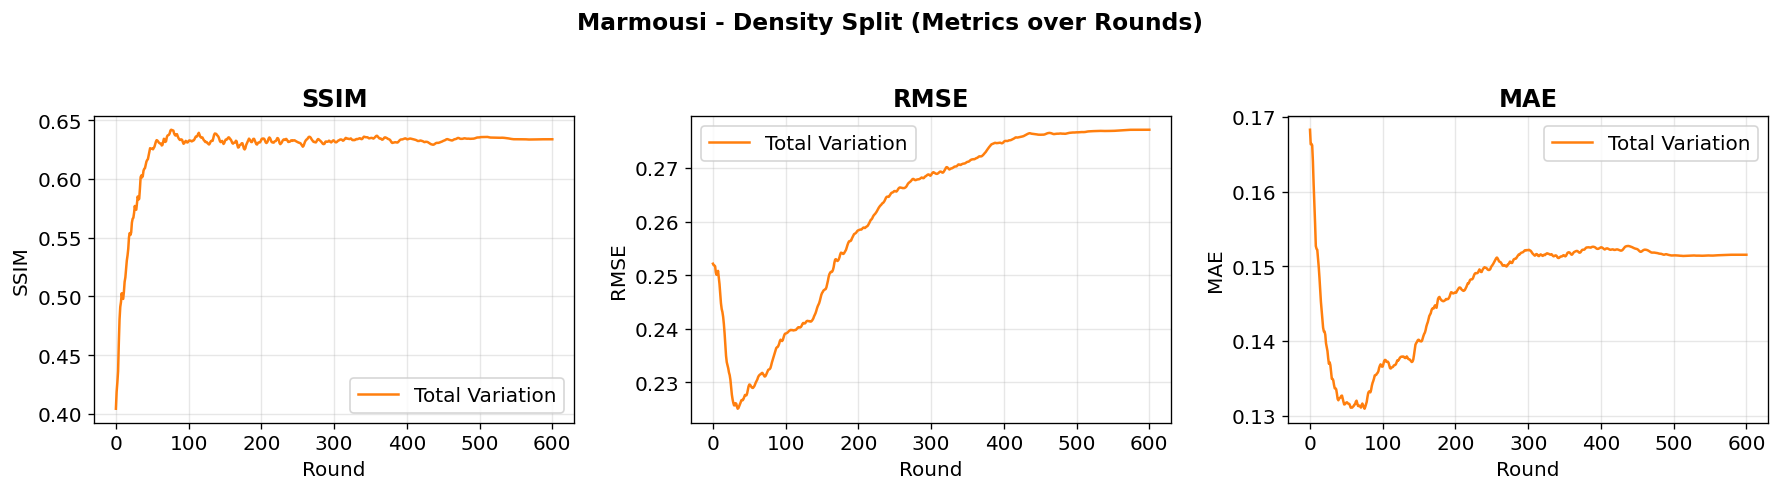

---


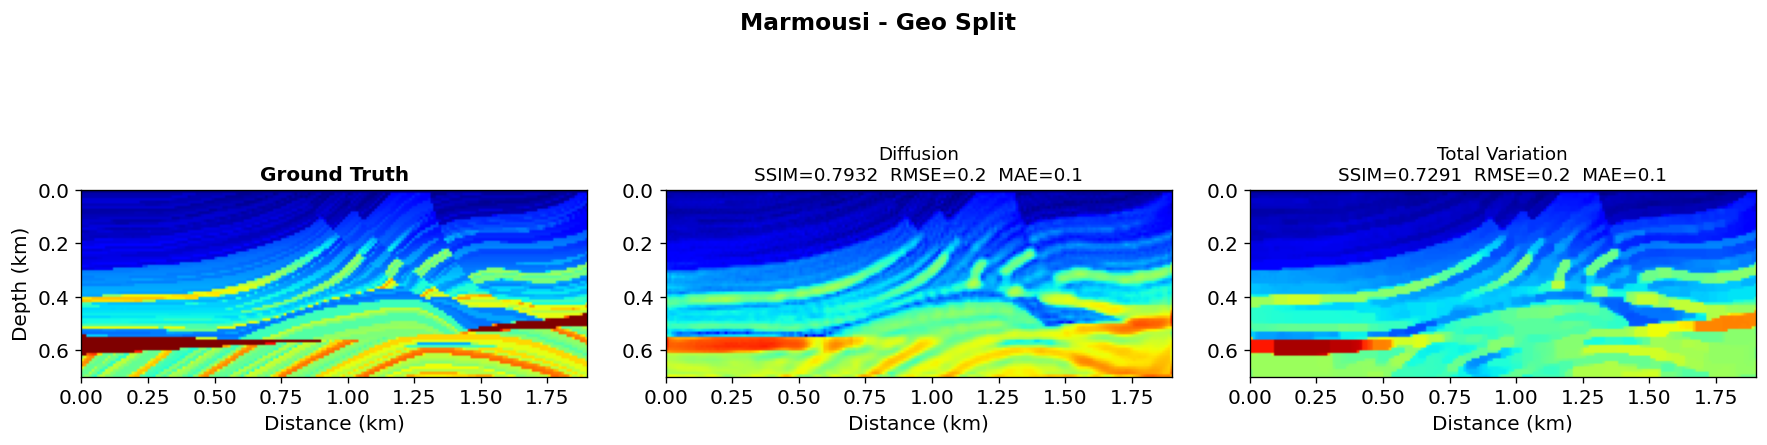

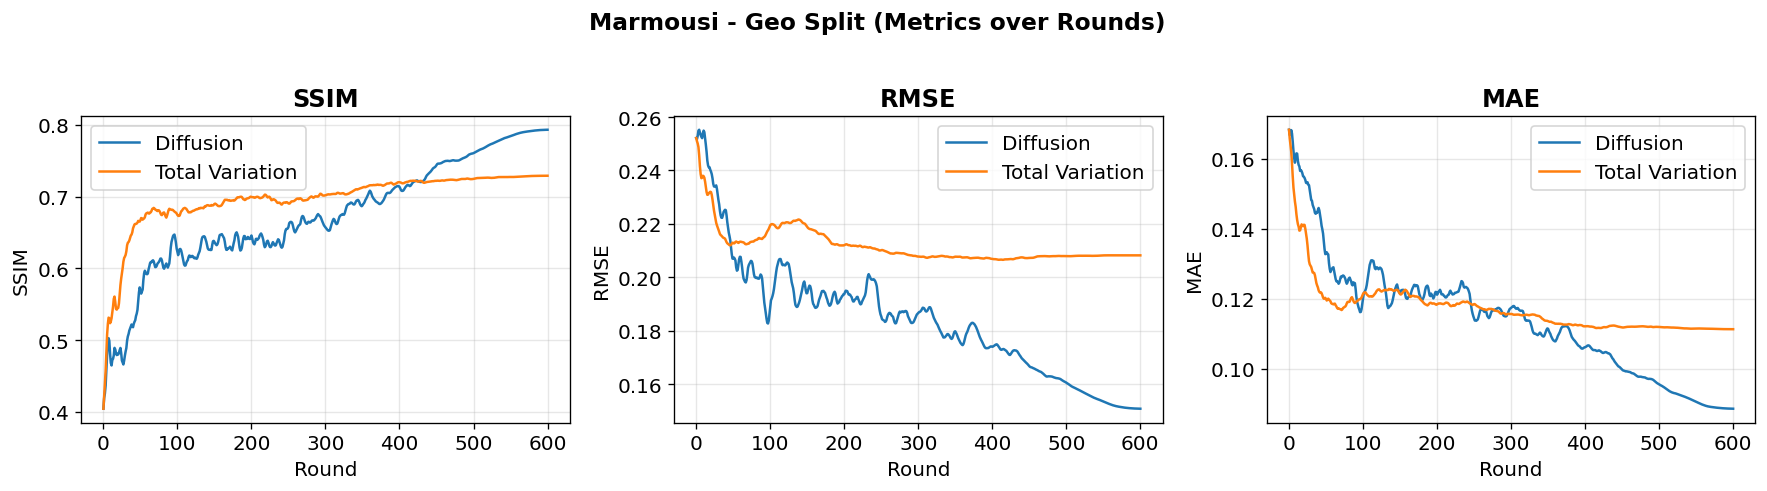

---


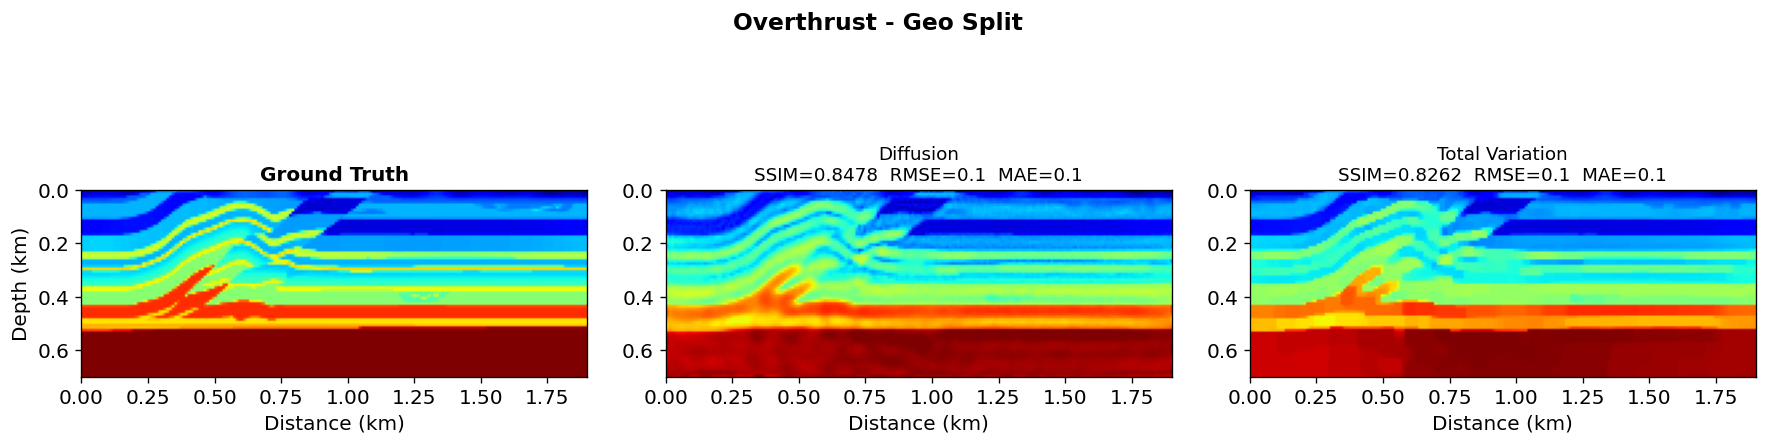

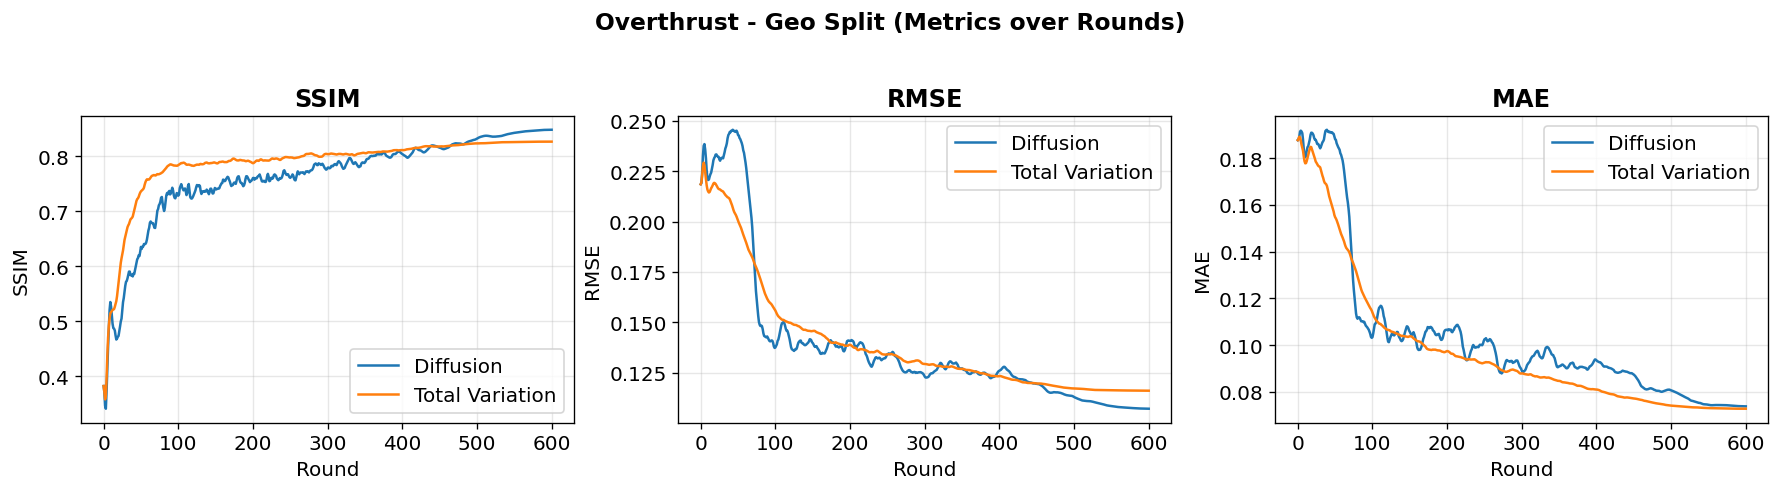

---


In [5]:
# Plot results for each (model, scenario) group
for (model, scenario), methods in sorted(results.items()):
    n_methods = len(methods)
    method_order = [m for m in ['diffusion', 'total_variation', 'tikhonov'] if m in methods]
    n = len(method_order)
    
    gt = gt_models[model]
    vmin, vmax = gt.min(), gt.max()
    extent = [0, gt.shape[1]*10/1000, gt.shape[0]*10/1000, 0]
    
    # --- Figure 1: Velocity model comparison ---
    fig, axes = plt.subplots(1, n + 1, figsize=(5 * (n + 1), 4))
    if n + 1 == 1:
        axes = [axes]
    
    # Ground truth
    im = axes[0].imshow(gt, aspect='equal', cmap='jet', extent=extent, vmin=vmin, vmax=vmax)
    axes[0].set_title('Ground Truth', fontsize=12, fontweight='bold')
    axes[0].set_xlabel('Distance (km)')
    axes[0].set_ylabel('Depth (km)')
    
    for i, method in enumerate(method_order):
        data = np.load(methods[method])
        mu = data['mu']  # already in [-1, 1]
        final_ssim = data['ssim'][-1]
        final_rmse = data['rmse'][-1]
        final_mae = data['mae'][-1]
        
        ax = axes[i + 1]
        im = ax.imshow(mu, aspect='equal', cmap='jet', extent=extent, vmin=vmin, vmax=vmax)
        ax.set_title(f'{METHOD_LABELS[method]}\nSSIM={final_ssim:.4f}  RMSE={final_rmse:.1f}  MAE={final_mae:.1f}',
                     fontsize=11)
        ax.set_xlabel('Distance (km)')
    
    fig.suptitle(f'{model.capitalize()} - {scenario.replace("_", " ").title()}',
                 fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()
    
    # --- Figure 2: Metrics over rounds ---
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    metric_names = ['ssim', 'rmse', 'mae']
    metric_titles = ['SSIM', 'RMSE', 'MAE']
    
    for j, (metric_key, metric_title) in enumerate(zip(metric_names, metric_titles)):
        ax = axes[j]
        for method in method_order:
            data = np.load(methods[method])
            rounds = data['rounds']
            values = data[metric_key]
            ax.plot(rounds, values, label=METHOD_LABELS[method],
                    color=METHOD_COLORS[method], linewidth=1.5)
        ax.set_xlabel('Round')
        ax.set_ylabel(metric_title)
        ax.set_title(metric_title, fontweight='bold')
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    fig.suptitle(f'{model.capitalize()} - {scenario.replace("_", " ").title()} (Metrics over Rounds)',
                 fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()
    print('---')

## 3. Summary Table: Final Metrics

In [6]:
# Summary table of final metrics
print(f'{"Model":>12s} | {"Scenario":>15s} | {"Method":>16s} | {"SSIM":>8s} | {"RMSE":>8s} | {"MAE":>8s}')
print('-' * 85)

for (model, scenario), methods in sorted(results.items()):
    method_order = [m for m in ['diffusion', 'total_variation', 'tikhonov'] if m in methods]
    for method in method_order:
        data = np.load(methods[method])
        print(f'{model:>12s} | {scenario:>15s} | {METHOD_LABELS[method]:>16s} | '
              f'{data["ssim"][-1]:>8.4f} | {data["rmse"][-1]:>8.2f} | {data["mae"][-1]:>8.2f}')

       Model |        Scenario |           Method |     SSIM |     RMSE |      MAE
-------------------------------------------------------------------------------------
      bpsalt |       geo_split |        Diffusion |   0.8934 |     0.12 |     0.06
      bpsalt |       geo_split |  Total Variation |   0.8877 |     0.12 |     0.07
    foothill |   density_split |        Diffusion |   0.7681 |     0.16 |     0.09
    foothill |   density_split |  Total Variation |   0.7412 |     0.30 |     0.21
    foothill |   density_split |         Tikhonov |   0.4335 |     0.96 |     0.71
    foothill |      freq_split |        Diffusion |   0.7670 |     0.11 |     0.07
    foothill |      freq_split |  Total Variation |   0.7367 |     0.17 |     0.11
    foothill |      freq_split |         Tikhonov |   0.5748 |     0.55 |     0.31
    foothill |       geo_split |        Diffusion |   0.8453 |     0.08 |     0.05
    foothill |       geo_split |  Total Variation |   0.7621 |     0.26 |     0.19
 